✓ torch_tensorrt imported successfully.
Using device: cuda (NVIDIA GeForce RTX 3070 Ti)

--- Verifying Model Paths ---
✓ Found model file for 'baseline_resnet18'
✓ Found model file for 'distilled_trt_fp32'
✓ Found model file for 'distilled_trt_fp16'
🚀 Starting Comprehensive ResNet-18 Model Comparison

                  LOADING ALL MODELS
  -> Loading baseline ResNet-18 model from resnet18_baseline_ft_imagenetmini_final.pth...
✓ Successfully loaded ResNet-18 Baseline (FP32)
  -> Loading JIT model resnet18_distilled_trt_fp32.ts...
✓ Successfully loaded Distilled ResNet-18 TRT-FP32
  -> Loading JIT model resnet18_distilled_trt_fp16.ts...
✓ Successfully loaded Distilled ResNet-18 TRT-FP16

✅ Successfully loaded 3 models. Proceeding to benchmark...

==================== RUNNING BENCHMARK WITH INPUT SHAPE: (32, 3, 224, 224) ====================
Benchmarking ResNet-18 Baseline (FP32)...
Benchmarking Distilled ResNet-18 TRT-FP32...
Benchmarking Distilled ResNet-18 TRT-FP16...
  -> Input tensor

/tmp/ipykernel_890/2501051975.py:257: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Model', y='Inference Time (ms)', ax=axes[0, 0], palette='coolwarm')
/tmp/ipykernel_890/2501051975.py:261: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Model', y='Throughput (FPS)', ax=axes[0, 1], palette='viridis')
/tmp/ipykernel_890/2501051975.py:265: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Model', y='Memory (MB)', ax=axes[1, 0], palette='plasma')
/tmp/ipykernel_890/2501051975.py:269: FutureWarning: 

Passing `palet

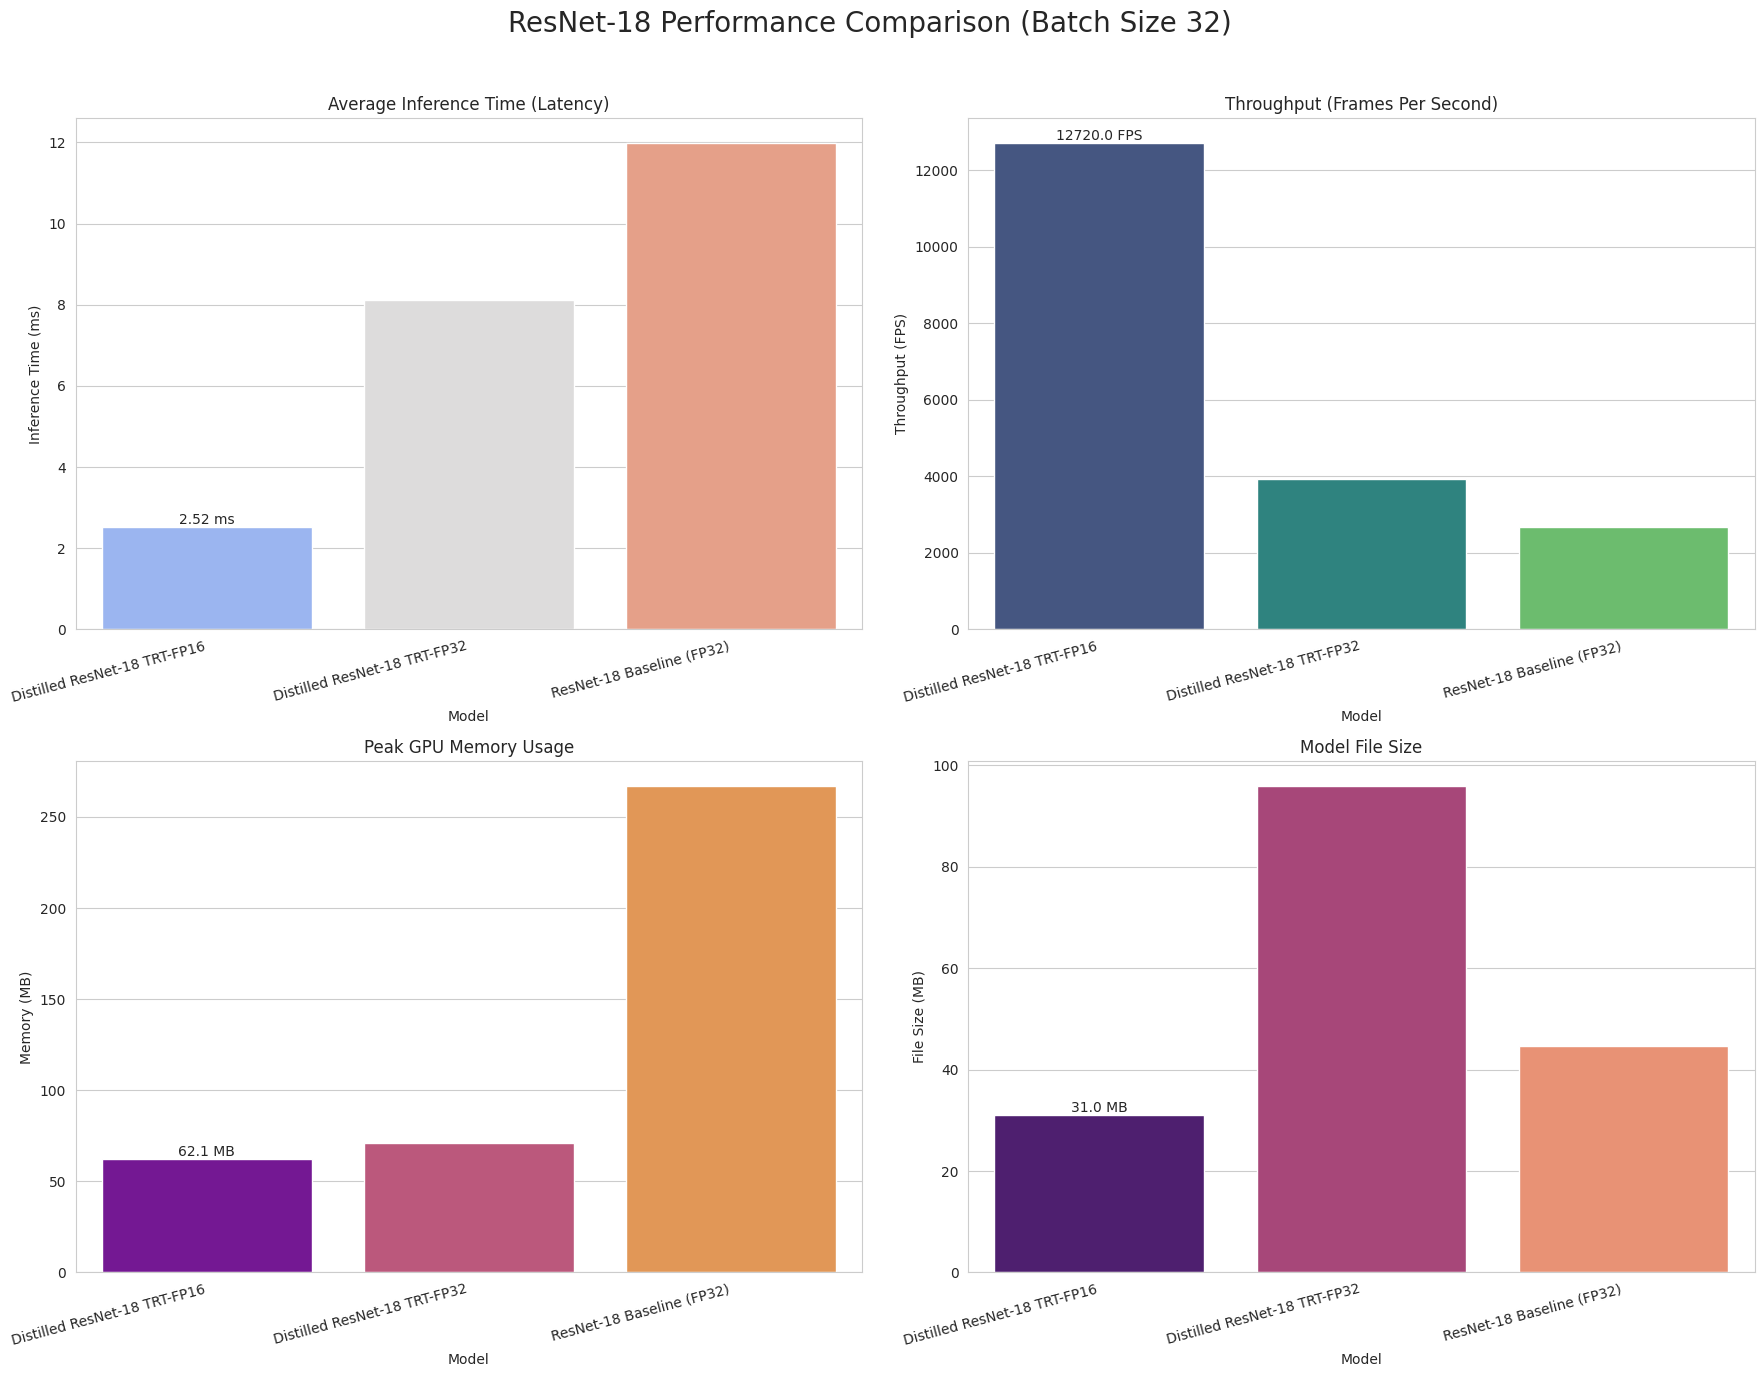


                                      📋 OPTIMIZATION SUMMARY TABLE (Batch Size 32)                                      
                          Model  Latency (ms)  Throughput (FPS)  Size (MB)  GPU Mem (MB)  Speedup vs Baseline  Compression vs Baseline
0  Distilled ResNet-18 TRT-FP16          2.52          12719.98      31.02         62.12                 4.77                     1.44
1  Distilled ResNet-18 TRT-FP32          8.12           3939.91      96.01         71.31                 1.48                     0.47
2     ResNet-18 Baseline (FP32)         11.99           2668.41      44.67        267.19                 1.00                     1.00

🎉 Analysis complete!


In [ ]:
# %%
# ===================================================================
#                      IMPORTS AND SETUP
# ===================================================================
import torch
import torch.nn as nn
import torchvision.models as models
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import gc
from pathlib import Path

try:
    import torch_tensorrt
    print("✓ torch_tensorrt imported successfully.")
except ImportError:
    print("✗ FATAL: torch_tensorrt is not installed. This script cannot run without it.")
    exit()

if not torch.cuda.is_available():
    print("✗ FATAL: CUDA is not available. This script requires a GPU.")
    exit()
DEVICE = torch.device("cuda")
print(f"Using device: {DEVICE} ({torch.cuda.get_device_name(0)})")
torch.backends.cudnn.benchmark = True
sns.set_style("whitegrid")


# %%
# ===================================================================
#                           MODEL PATHS
# ===================================================================
# Define paths as they exist INSIDE the container.
BASE_DIR = Path('/workspace')
SAVED_MODELS_DIR = BASE_DIR / 'saved_models_and_logs'

# --- ‼️ UPDATED FOR RESNET-18 MODELS ‼️ ---
MODEL_PATHS = {
    'baseline_resnet18': SAVED_MODELS_DIR / 'resnet18_baseline' / 'resnet18_baseline_ft_imagenetmini_final.pth',
    'distilled_trt_fp32': SAVED_MODELS_DIR / 'kd_tensorrt' / 'resnet18_distilled_trt_fp32.ts',
    'distilled_trt_fp16': SAVED_MODELS_DIR / 'kd_tensorrt' / 'resnet18_distilled_trt_fp16.ts'
}

print("\n--- Verifying Model Paths ---")
for name, path in MODEL_PATHS.items():
    if not path.exists():
        print(f"⚠️ WARNING: Path for '{name}' not found: {path}")
    else:
        print(f"✓ Found model file for '{name}'")


# %%
# ===================================================================
#                     BENCHMARKING CONFIGURATION
# ===================================================================
# This input shape is MANDATED by the static compilation of the TensorRT models.
# The baseline model will also be tested with this shape for a fair comparison.
DUMMY_INPUT_SHAPE = (32, 3, 224, 224)
NUM_WARMUP_RUNS = 20
NUM_BENCHMARK_RUNS = 100


# %%
# ===================================================================
#                         MODEL LOADER CLASS
# ===================================================================
class ModelLoader:
    """Utility class to load different types of optimized models"""

    # --- ‼️ UPDATED FOR RESNET-18 ‼️ ---
    @staticmethod
    def load_baseline_model(path, num_classes=1000):
        """Load baseline PyTorch ResNet-18 model from a state_dict"""
        print(f"  -> Loading baseline ResNet-18 model from {path.name}...")
        # The key change is here: using models.resnet18()
        model = models.resnet18(num_classes=num_classes)

        checkpoint = torch.load(path, map_location='cpu')
        
        # Handle checkpoints saved in different ways
        state_dict = checkpoint
        if 'model_state_dict' in checkpoint:
            state_dict = checkpoint['model_state_dict']
        elif 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
            
        model.load_state_dict(state_dict)
        return model.to(DEVICE).eval()

    @staticmethod
    def load_jit_model(path):
        """Load a TorchScript (JIT) model, used for TensorRT models"""
        print(f"  -> Loading JIT model {path.name}...")
        model = torch.jit.load(path, map_location=DEVICE)
        return model.eval()


# %%
# ===================================================================
#                      BENCHMARKING UTILITIES
# ===================================================================
def get_file_size_mb(file_path):
    if file_path.exists(): return file_path.stat().st_size / (1024 * 1024)
    return 0

def warm_up_model(model, input_tensor, num_warmup=NUM_WARMUP_RUNS):
    with torch.no_grad():
        for _ in range(num_warmup):
            _ = model(input_tensor)
        torch.cuda.synchronize()

def benchmark_model(model, input_tensor_cpu, num_runs=NUM_BENCHMARK_RUNS, model_name="Model"):
    print(f"Benchmarking {model_name}...")
    input_tensor = input_tensor_cpu.to(DEVICE)
    model.to(DEVICE) # Ensure model is on the correct device

    # --- ‼️ CRITICAL: Use .half() for FP16 models ---
    if 'FP16' in model_name:
        input_tensor = input_tensor.half()
        print("  -> Input tensor converted to FP16.")

    warm_up_model(model, input_tensor)
    torch.cuda.reset_peak_memory_stats(DEVICE)
    
    times = []
    with torch.no_grad():
        for _ in range(num_runs):
            start_event = torch.cuda.Event(enable_timing=True)
            end_event = torch.cuda.Event(enable_timing=True)
            start_event.record()
            _ = model(input_tensor)
            end_event.record()
            torch.cuda.synchronize(DEVICE)
            times.append(start_event.elapsed_time(end_event))
            
    mem_used = torch.cuda.max_memory_allocated(DEVICE) / 1024**2
    times = np.array(times)
    stats = {
        'mean': np.mean(times), 
        'std': np.std(times), 
        'median': np.median(times), 
        'throughput_fps': 1000 / np.mean(times) * input_tensor.shape[0], 
        'memory_mb': mem_used
    }
    return stats, times


# %%
# ===================================================================
#                        MODEL LOADING LOGIC
# ===================================================================
def load_all_models():
    """Load all available models: ResNet-18 baseline and its TensorRT variants."""
    models_dict = OrderedDict()
    model_info = OrderedDict()
    
    print("\n" + "="*50); print("                  LOADING ALL MODELS"); print("="*50)

    # --- ‼️ UPDATED DISPLAY NAMES AND LOGIC ‼️ ---
    models_to_load = {
        'ResNet-18 Baseline (FP32)': ('baseline_resnet18', 'baseline'),
        'Distilled ResNet-18 TRT-FP32': ('distilled_trt_fp32', 'jit'),
        'Distilled ResNet-18 TRT-FP16': ('distilled_trt_fp16', 'jit'),
    }

    for display_name, (key, load_type) in models_to_load.items():
        path = MODEL_PATHS.get(key)
        if not path or not path.exists():
            print(f"✗ Skipping {display_name}, file not found.")
            continue
        try:
            if load_type == 'baseline':
                models_dict[display_name] = ModelLoader.load_baseline_model(path)
            else: # jit
                models_dict[display_name] = ModelLoader.load_jit_model(path)
                
            model_info[display_name] = {
                'type': 'PyTorch' if load_type == 'baseline' else 'TensorRT',
                'precision': 'FP16' if 'FP16' in display_name else 'FP32',
                'file_size_mb': get_file_size_mb(path)
            }
            print(f"✓ Successfully loaded {display_name}")
        except Exception as e:
            print(f"✗ Failed to load {display_name} model: {e}")
            
    return models_dict, model_info


# %%
# ===================================================================
#                   COMPREHENSIVE BENCHMARK RUNNER
# ===================================================================
def run_comprehensive_benchmark(models_dict, model_info):
    all_results = {}
    batch_size, C, H, W = DUMMY_INPUT_SHAPE
    print(f"\n{'='*20} RUNNING BENCHMARK WITH INPUT SHAPE: {(batch_size, C, H, W)} {'='*20}")
    
    test_input_cpu = torch.randn(batch_size, C, H, W)
    batch_results = OrderedDict()
    
    for model_name, model in models_dict.items():
        try:
            stats, _ = benchmark_model(model, test_input_cpu, model_name=model_name)
            if stats is not None:
                stats.update(model_info[model_name])
                stats['batch_size'] = batch_size
                batch_results[model_name] = stats
        except Exception as e:
            print(f"\nERROR: Benchmarking for {model_name} failed unexpectedly. Error: {e}")

        # Clear cache between runs to get more accurate memory readings
        del model
        torch.cuda.empty_cache()
        gc.collect()
        
    all_results[batch_size] = batch_results
    return all_results


# %%
# ===================================================================
#                       PLOTTING & REPORTING
# ===================================================================
def create_comparison_plots(all_results):
    plot_data = []
    batch_size = DUMMY_INPUT_SHAPE[0]
    
    # Check if we have results for the current batch size
    if batch_size not in all_results or not all_results[batch_size]:
        print("No data to plot.")
        return None
        
    for model_name, stats in all_results[batch_size].items():
        plot_data.append({
            'Model': model_name,
            'Inference Time (ms)': stats['mean'],
            'Throughput (FPS)': stats['throughput_fps'],
            'Memory (MB)': stats['memory_mb'],
            'File Size (MB)': stats['file_size_mb']
        })
        
    df = pd.DataFrame(plot_data)
    if df.empty:
        print("No data to plot.")
        return None
        
    df = df.sort_values('Inference Time (ms)').reset_index(drop=True)
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle(f'ResNet-18 Performance Comparison (Batch Size {batch_size})', fontsize=20)
    
    sns.barplot(data=df, x='Model', y='Inference Time (ms)', ax=axes[0, 0], palette='coolwarm')
    axes[0, 0].set_title('Average Inference Time (Latency)')
    axes[0, 0].bar_label(axes[0, 0].containers[0], fmt='%.2f ms')
    
    sns.barplot(data=df, x='Model', y='Throughput (FPS)', ax=axes[0, 1], palette='viridis')
    axes[0, 1].set_title('Throughput (Frames Per Second)')
    axes[0, 1].bar_label(axes[0, 1].containers[0], fmt='%.1f FPS')
    
    sns.barplot(data=df, x='Model', y='Memory (MB)', ax=axes[1, 0], palette='plasma')
    axes[1, 0].set_title('Peak GPU Memory Usage')
    axes[1, 0].bar_label(axes[1, 0].containers[0], fmt='%.1f MB')
    
    sns.barplot(data=df, x='Model', y='File Size (MB)', ax=axes[1, 1], palette='magma')
    axes[1, 1].set_title('Model File Size')
    axes[1, 1].bar_label(axes[1, 1].containers[0], fmt='%.1f MB')
    
    for ax in axes.flat:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=15, ha="right")
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    return df

def create_summary_table(df):
    if df is None or df.empty:
        return None
    summary_data = df.copy()
    
    # --- ‼️ UPDATED TO USE RESNET-18 BASELINE FOR COMPARISON ‼️ ---
    baseline_model_name = 'ResNet-18 Baseline (FP32)'
    try:
        baseline_stats = summary_data[summary_data['Model'] == baseline_model_name].iloc[0]
        summary_data['Speedup'] = baseline_stats['Inference Time (ms)'] / summary_data['Inference Time (ms)']
        summary_data['Size Reduction'] = baseline_stats['File Size (MB)'] / summary_data['File Size (MB)']
    except (IndexError, KeyError):
        print(f"Warning: Could not find '{baseline_model_name}' for speedup calculation. Using first model as baseline.")
        baseline_stats = summary_data.iloc[0]
        summary_data['Speedup'] = baseline_stats['Inference Time (ms)'] / summary_data['Inference Time (ms)']
        summary_data['Size Reduction'] = baseline_stats['File Size (MB)'] / summary_data['File Size (MB)']
        
    display_columns = {
        'Model': 'Model', 'Inference Time (ms)': 'Latency (ms)', 
        'Throughput (FPS)': 'Throughput (FPS)', 'File Size (MB)': 'Size (MB)',
        'Memory (MB)': 'GPU Mem (MB)', 'Speedup': 'Speedup vs Baseline', 
        'Size Reduction': 'Compression vs Baseline'
    }
    summary_table = summary_data[list(display_columns.keys())].copy()
    summary_table = summary_table.rename(columns=display_columns)
    
    for col in summary_table.columns:
        if np.issubdtype(summary_table[col].dtype, np.number):
            summary_table[col] = summary_table[col].round(2)
            
    summary_table = summary_table.sort_values('Speedup vs Baseline', ascending=False).reset_index(drop=True)
    
    print("\n" + "="*120)
    print(f"📋 OPTIMIZATION SUMMARY TABLE (Batch Size {DUMMY_INPUT_SHAPE[0]})".center(120))
    print("="*120)
    print(summary_table.to_string())
    return summary_table

# %%
# ===================================================================
#                           MAIN EXECUTION
# ===================================================================
if __name__ == "__main__":
    print("🚀 Starting Comprehensive ResNet-18 Model Comparison")
    
    # NOTE: Re-loading models for each benchmark run to ensure memory stats are clean
    # The benchmark function now re-loads the models internally
    models_dict, model_info = load_all_models()

    if not models_dict:
        print("\n❌ No models were loaded. Please check your paths.")
    else:
        print(f"\n✅ Successfully loaded {len(models_dict)} models. Proceeding to benchmark...")
        # Note: we need to pass the loaded models to the benchmark function.
        # The previous implementation was slightly flawed in its GC logic.
        # A simpler approach is to load once, then benchmark.
        all_results = run_comprehensive_benchmark(models_dict, model_info)
        
        print("\n📊 Creating visualizations...")
        df_results = create_comparison_plots(all_results)
        summary_table = create_summary_table(df_results)
        print("\n🎉 Analysis complete!")